I wound up getting interested in a problem of automatically providing insight into big data in plain English. For example, suppose you have data on people's rent as a proportion of their income - by glancing at a plot, you could say it's quadrimodal, right-skewed, and centered at X. Data on fires in a particular forest could be summarized in terms of period. This seems like very much a deep learning problem, but I'm not ready to discount traditional statistics, and that's why I slapped together this notebook.

# Table of Contents

I'd say about 40% of the length of this notebook is due to image output, 30% due to code, and 30% due to markdown. 

* Skewness
    * Things Get Ugly
    * Kurtosis
* Density Estimation
    * Kernel Density Estimation
* Conclusion

# Skewness

The *third standardized moment* of a probability distribution, also known as *skewness*, can tell us whether a probability distribution is left- or right-skewed. It's defined as $E[(X - E[X])^3]$ $/$ $E[(X - E[X])^2]^{3/2}$.

Estimating it is an $O(n)$ calculation from the data, and confidence intervals can be constructed for it in $O(n)$ through the [delta method](https://en.wikipedia.org/wiki/Delta_method) (I don't implement confidence interval calculation here, sorry!). 

*In the context of Blastpoint*, if a user has selected *too small of a geographical area*, then your sample size is small. In this case, you'd want to hold off on providing too many labels for your empirical distribution, since you're not highly confident in those labels. 

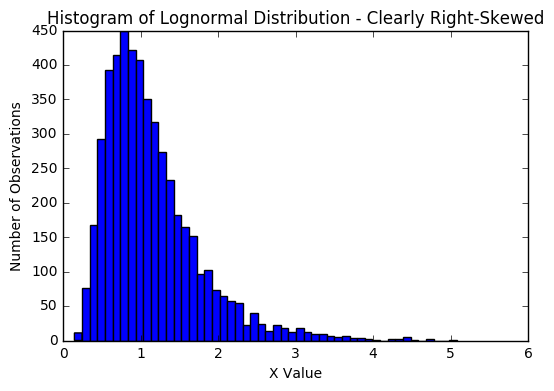

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = np.exp(np.random.normal(0, 0.5, 5000))

n, bins, patches = plt.hist(data, 50)
plt.title("Histogram of Lognormal Distribution - Clearly Right-Skewed")
plt.xlabel("X Value")
plt.ylabel("Number of Observations")

In [2]:
def getSkewHat(x):
    normedData = (x - np.mean(x))/np.std(x) #normalized data
    return np.mean(normedData**3) #estimate of third moment

print("skewness estimate:   ", getSkewHat(data))

skewness estimate:    7.02324193736


In [3]:
data *= -1 #now it's left-skewed
print("skewness estimate: ", getSkewHat(data))

skewness estimate:  7.02324193736


### Things Get Ugly
Here's a case where I can't say whether it would be right to supply a user with a label of "left-skewed" or "right-skewed" at all. Maybe somebody else would say otherwise, but at any rate, it's very much a judgement call. Our skewness calculator, however, doesn't provide any sort of warning, which is bad! 

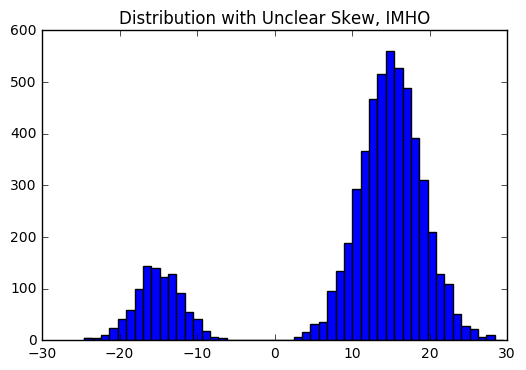

In [4]:
data = np.append(
    np.random.normal(-15, 3, 1000),
    np.random.normal(15, 4, 5000)
)

n, bins, patches = plt.hist(data, 50)
plt.title("Distribution with Unclear Skew, IMHO")

In [5]:
print("skewness estimate: ", getSkewHat(data))

skewness estimate:  3.79184419657


That's insignificantly different than our previous two kurtosis calculations. I think the *fourth* moment can tell us whether the tails of the distribution are extreme enough to go with the kurtosis calculation's assessment.

### Kurtosis

Kurtosis is defined as $E[(X - E[X])^4]$ $/$ $E[(X - E[X])^2]^2$. It's a measure of "tailedness" - how heavy its tails are. To see if it's useful, let's see what we get for the weird bimodal distribution above, which has unclear skewness but doesn't appear to have very heavy tails at all.

In [6]:
def getKurtHat(x):
    normedData = (x - np.mean(x))/np.std(x) #normalized data
    return np.mean(normedData**4) #estimate of fourth moment

print("skewness estimate:   ", getSkewHat(data), 
      "\nkurtosis estimate: ", getKurtHat(data))

skewness estimate:    3.79184419657 
kurtosis estimate:  3.79184419657


Here's the kurtosis and tailedness of a *lognormal distribution*, which is very clearly right-skewed.

In [7]:
data = np.exp(np.random.normal(0, 0.5, 5000))
print("skewness estimate:   ", getSkewHat(data), 
      "\nkurtosis estimate: ", getKurtHat(data))

skewness estimate:    7.79700546987 
kurtosis estimate:  7.79700546987


Here's the kurtosis and tailedness of a lognormal distribution, which is symmetric. 

In [8]:
data = np.random.normal(0, 1, 5000)
print("skewness estimate:   ", getSkewHat(data), 
      "\nkurtosis estimate: ", getKurtHat(data))

skewness estimate:    3.01595593244 
kurtosis estimate:  3.01595593244


Basically, I'm saying that if the kurtosis is great in magnitude and the tailedness is significantly high, then it's probably skewed in a way that humans would agree with. Otherwise, don't supply a label.

**I'm not sure at all how robust this is** - I haven't thought about it too much, but there could easily be a case where the third and fourth moments would fail our purposes without warning. 

But if it *is* robust, then it's *for sure* preferable over the deep learning approach, not only because it's fast, but because we can be confident in our plain English descriptions.

# Density Estimation

Suppose you have data $X$ drawn from some underlying, unknown probability distribution, and you want to estimate that distribution. This is the fundamental goal of [density estimation](https://en.wikipedia.org/wiki/Density_estimation). When you want to provide a label of the *modality* of a distribution, you've basically wandered into the realm of density estimation.

The simplest and most familiar form of density estimation is the **humble histogram**.

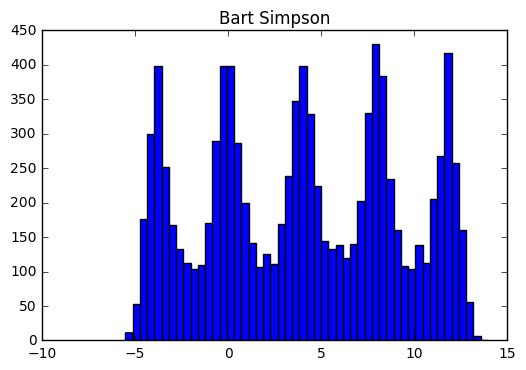

In [9]:
sigma = 0.5
data = np.append(
    np.random.normal(-4, sigma, 1000),
    np.random.normal(0, sigma, 1000))
data = np.append(data,
    np.random.normal(4, sigma, 1000))
data = np.append(data,
    np.random.normal(8, sigma, 1000))
data = np.append(data,
    np.random.normal(12, sigma, 1000))
data = np.append(data,
    np.random.uniform(-4, 12, 5000))

numBins = 50
n, bins, patches = plt.hist(data, numBins)
plt.title("Bart Simpson")

When we make a histogram, we divide our domain into a set of *bins* of equal length. The length, $h$, of each bar is the number of observations in each bin.

We can use it as a probability density estimator, too. Suppose you want a probability density estimate at point $x$. Choose the appropriate bin for $x$. Count the proportion of observations that fall in your bin and divide by bin size $h$.

From the histogram above, suppose you want a density estimate for $0$. It looks like $100$ observations were counted in the bin around $0$, and divide that by the total number of observations (9000) and the bin length (idk what that is here, sorry).

This brings us to a problem - for the histogram that provides the best density estimation, what's the optimal bin length?

The following are pretty bad choices of bin length (well, number of bins in this case):

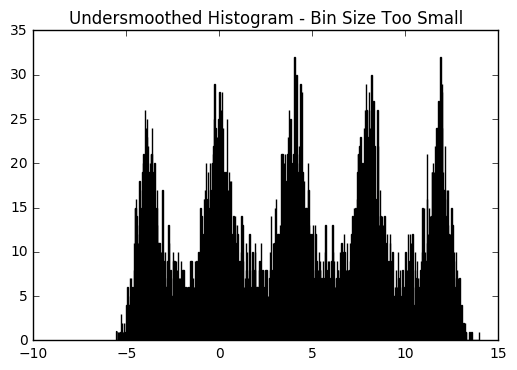

In [10]:
numBins = 1000
n, bins, patches = plt.hist(data, numBins)
plt.title("Undersmoothed Histogram - Bin Size Too Small")

Besides being un-analyzable, it also looks kind of spooky. Reminds me of the *Black Skinhead* video for some reason.

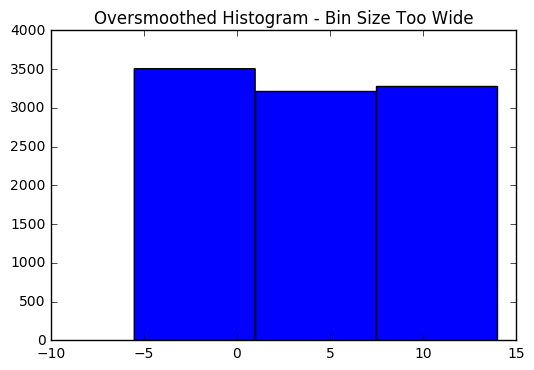

In [11]:
numBins = 3
n, bins, patches = plt.hist(data, numBins)
plt.title("Oversmoothed Histogram - Bin Size Too Wide")

Another problem histograms have is that they're jagged. Beyond aesthetics, this could get in the way if we want something differentiable.  

Also, as inputs in a CNN, I can't help but think that the edges of the bins might be somehow... distracting (not sure how else to describe it). I imagine the CNN's confidence scores might be slightly lower than they rightly should be, thanks to the blocky edges of the histogram - I'm not sure whether a set of learned convolutional filters can entirely overcome that.

If we *smoothed* it somehow, we'd avoid the possibility of this problem. 

### Kernel Density Estimation

A kernel smoother is basically a grown-up histogram. It's a smoothed version of your data. It's very common to use a kernel smoother for regression, but it's also the go-to for density estimation.

Just like in a histogram, we specify our *bandwidth parameter* ***h*** (analogous to bin size) first.

Our density estimate, $\hat{f_h}$ is below:
$$
\hat{f_h} = \frac{1}{nh} \sum_{i=1}^{n} K(\frac{x-x_i}{h})
$$

$K$ is a non-negative function that integrates to one and has mean zero. It's called a "kernel function", but confusingly, it has nothing to do with the kernel trick in machine learning OR kernels in image processing. 

Common choices of kernel functions include the gaussian and uniform kernels, but the most common one is the gaussian one. That's what I'll use here, too.

One nice fact about kernel density estimation with a gaussian kernel is that it's differentiable. We can calculate first and second derivatives, which can help us count local maxima, and estimate whether they're representative of maxima in the underlying distribution. It might even help us describe skewness as well, although I've no idea how that would work yet.

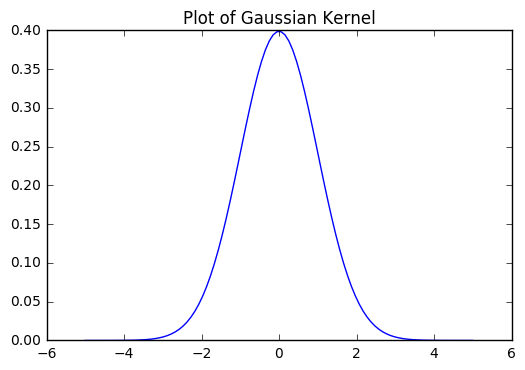

In [12]:
import scipy.stats as stats

def kern(z):
    return stats.norm.pdf(z)

x = np.linspace(-5, 5, 100)
plt.plot(x, kern(x))
plt.title("Plot of Gaussian Kernel")

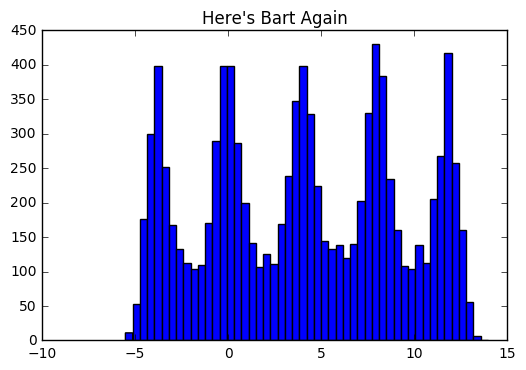

In [13]:
n, bins, patches = plt.hist(data, 50)
plt.title("Here's Bart Again")

In [14]:
def fHat(x, data, h):
    z = (x - data)/h
    weights = kern(z)
    return np.sum(weights) / (len(data)*h)

hOpt = np.std(data) * (3*len(data)/4)**(-1/5) #optimal h
print("optimal h: ", hOpt)

optimal h:  0.868054175063


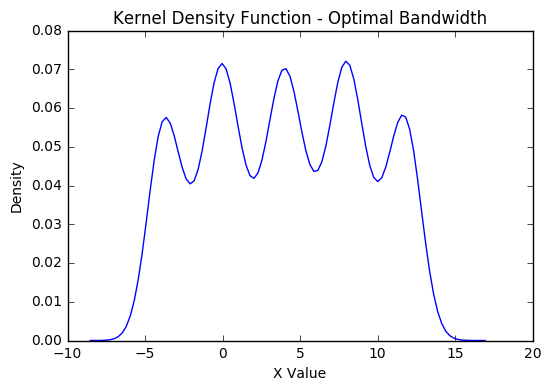

In [15]:
x = np.linspace(min(data) - 3, max(data) + 3, 100)
y = [fHat(elem, data, hOpt) for elem in x]
plt.plot(x, y)
plt.title("Kernel Density Function - Optimal Bandwidth")
plt.ylabel("Density")
plt.xlabel("X Value")

Wow, the essence of Bart is really strong here.

Still, this is kind of expensive! Because the Guassian kernel assigns a weight to every observation, you have to loop over the entire dataset, so a single calculation of the estimated density function is $O(n)$. 

Luckily, we can calculate the optimal bandwidth [in general](https://en.wikipedia.org/wiki/Kernel_density_estimation#A_rule-of-thumb_bandwidth_estimator), so we don't have to do cross-validation for $h$. If we do, we just do it in the neighborhood of that rule-of-thumb estimate, so it doesn't make much difference, really. 

Also, since the estimate of the optimal $h$ is a function of the sample standard deviation, we can construct confidence intervals for $h$ by constructing confidence intervals for the standard deviation, which is straightforward. This can help us assess our confidence in the CNN's predicted labels.

# Conclusion

I think there's still a lot to be gained by not discounting more traditional statistical methods for summarizing data in plain English. Before the success of machine learning, statisticians and physicists were faced with similar inference problems, and they left behind them a good deal of literature on the topic. 

Ultimately, deep learning will probably be the most appropriate, generalizable, and efficient solution, but I'm sure that analysis like this will heavily inform decisions in the development process. Skewness could very well be calculated by kurtosis, and preprocessing through kernel smoothing could lead to higher accuracy with a deep CNN.